
# Data Science Practicals – Final Assignment  
**Bike Sharing Demand Prediction & Forecasting**

Name: Arne Geiken  
Dataset: Bike Sharing Dataset (`hour.csv`)  
Python Version: 3.x  

This notebook fully solves all tasks of the final assignment using the hourly bike sharing dataset.
ChatGPT was used for structuring, explanations and code scaffolding.


## Imports & Environment

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)


## Task 1 – Describe the Dataset

### Load Dataset

In [5]:

df = pd.read_csv("hour.csv")
df["datetime"] = pd.to_datetime(df["dteday"]) + pd.to_timedelta(df["hr"], unit="h")
df.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011-01-01 00:00:00
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011-01-01 01:00:00
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011-01-01 02:00:00
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,2011-01-01 03:00:00
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,2011-01-01 04:00:00


### Basic Information

In [6]:

print("Rows, Columns:", df.shape)
print("Time range:", df["datetime"].min(), "to", df["datetime"].max())
df.info()


Rows, Columns: (17379, 18)
Time range: 2011-01-01 00:00:00 to 2012-12-31 23:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  object        
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64   

### Target & Features

In [7]:

target = "cnt"
features = [
    "season", "mnth", "hr", "weekday", "holiday", "workingday",
    "weathersit", "temp", "hum", "windspeed"
]

df[features + [target]].head()


,season,mnth,hr,weekday,holiday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,1,0,6,0,0,1,0.24,0.81,0.0,16
1,1,1,1,6,0,0,1,0.22,0.80,0.0,40
2,1,1,2,6,0,0,1,0.22,0.80,0.0,32
3,1,1,3,6,0,0,1,0.24,0.75,0.0,13
4,1,1,4,6,0,0,1,0.24,0.75,0.0,1


### Erklärung der folgenden Schritte

In den nächsten Codezeilen werden die Zielvariable (`target`) und die zu verwendenden Merkmale (`features`) für die Analyse festgelegt. 

- **`target = "cnt"`**: Hier wird die Zielvariable definiert, die vorhergesagt werden soll. In diesem Fall ist das die Gesamtanzahl der Fahrradverleihvorgänge (`cnt`).
- **`features = [...]`**: In dieser Liste werden alle Merkmale (Features) aufgelistet, die als Prädiktoren für das Modell verwendet werden. Dazu gehören saisonale, zeitliche und wetterbezogene Variablen.
- **`df[features + [target]].head()`**: Mit diesem Befehl werden die ersten Zeilen des DataFrames angezeigt, die nur die ausgewählten Merkmale und die Zielvariable enthalten. Dies dient zur Kontrolle, ob die Auswahl korrekt ist und die Daten wie erwartet aussehen.

Diese Schritte sind wichtig, um die Grundlage für die weitere Datenanalyse und das Modelltraining zu schaffen.

### Missing Values & Duplicates

In [8]:

df.isnull().sum(), df.duplicated().sum()


(instant       0
 dteday        0
 season        0
 yr            0
 mnth          0
 hr            0
 holiday       0
 weekday       0
 workingday    0
 weathersit    0
 temp          0
 atemp         0
 hum           0
 windspeed     0
 casual        0
 registered    0
 cnt           0
 datetime      0
 dtype: int64,
 np.int64(0))

### Descriptive Statistics

In [9]:

df.describe()


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,datetime
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088,2012-01-02 15:41:22.858622464
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2011-01-01 00:00:00
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,2011-07-04 22:30:00
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,2012-01-02 21:00:00
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,2012-07-02 06:30:00
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,2012-12-31 23:00:00
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599,NaN


### Visualisations

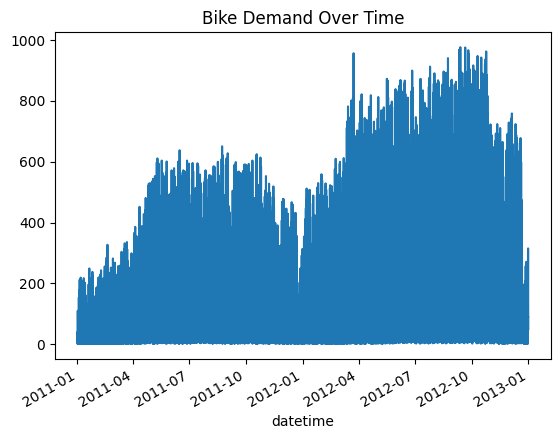

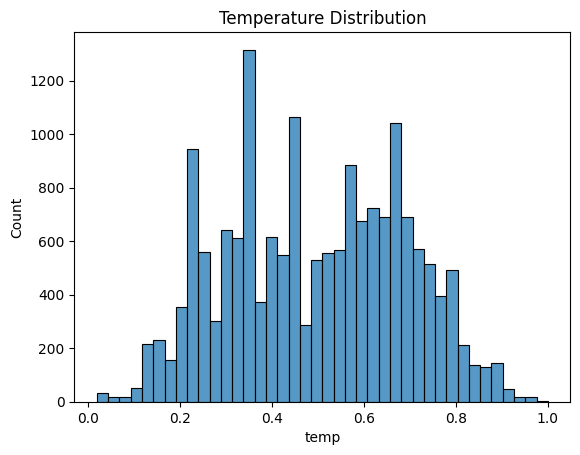

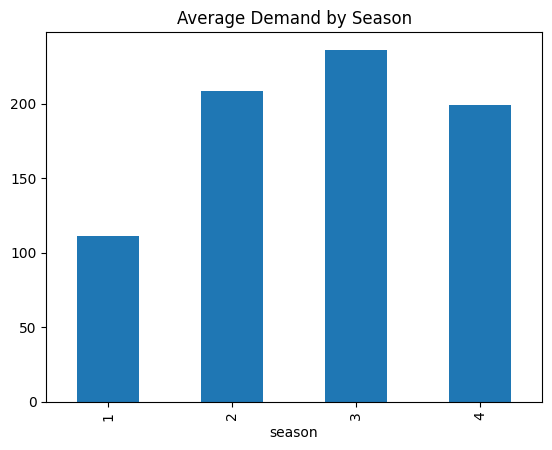

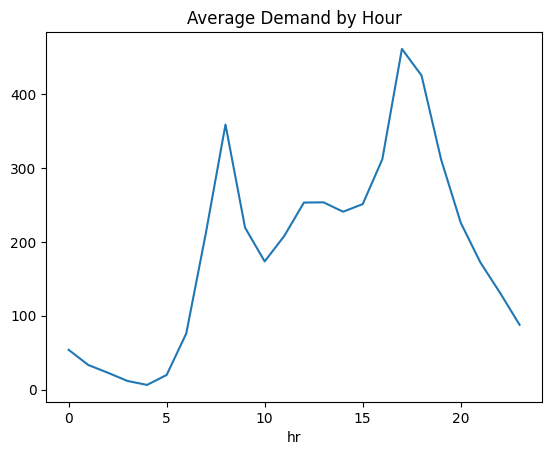

In [ ]:

plt.figure()
df.set_index("datetime")["cnt"].plot(title="Bike Demand Over Time")
plt.show()

sns.histplot(df["temp"], kde=True)
plt.title("Temperature Distribution")
plt.show()

df.groupby("season")["cnt"].mean().plot(kind="bar", title="Average Demand by Season")
plt.show()

df.groupby("hr")["cnt"].mean().plot(title="Average Demand by Hour")
plt.show()



**Summary:**  
The data shows strong daily and seasonal patterns. Bike demand peaks during commuting hours
and is significantly higher in summer and fall. Weather conditions and temperature have a clear
influence on demand, while demand drops during bad weather and holidays.


## Task 2 – Predict Demand from Conditions

### Feature Selection

In [11]:

X = df[features]
y = df[target]


### Preprocessing & Split

In [12]:

cat_features = ["season", "weekday", "weathersit"]
num_features = ["mnth", "hr", "temp", "hum", "windspeed", "holiday", "workingday"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


### Model Training

In [13]:

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42
)

pipe = Pipeline([
    ("prep", preprocessor),
    ("model", model)
])

pipe.fit(X_train, y_train)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluation

In [14]:

y_pred = pipe.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse, mae, r2


(np.float64(122.56634959618522), 85.73985144145706, 0.6909810404318364)

### Predicted vs Actual

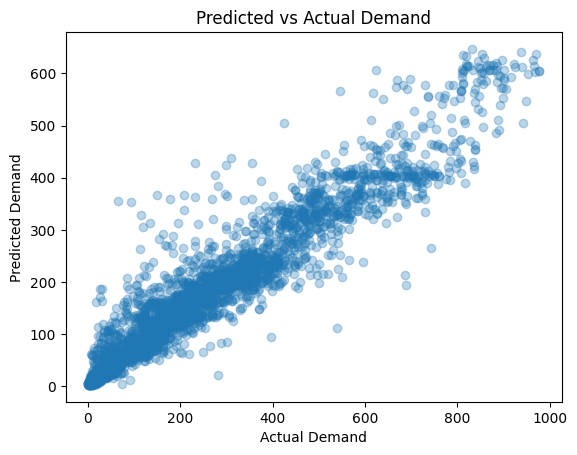

In [15]:

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Predicted vs Actual Demand")
plt.show()


### User Input Prediction

In [16]:

def predict_demand(input_dict):
    input_df = pd.DataFrame([input_dict])
    return int(pipe.predict(input_df)[0])

example = {
    "season": 2,
    "mnth": 7,
    "hr": 17,
    "weekday": 1,
    "holiday": 0,
    "workingday": 1,
    "weathersit": 1,
    "temp": 0.7,
    "hum": 0.5,
    "windspeed": 0.2
}

predict_demand(example)


644

## Task 3 – 30-Step Forecast

### Feature Engineering

In [17]:

df_ts = df.sort_values("datetime").copy()

for lag in [1, 24, 168]:
    df_ts[f"lag_{lag}"] = df_ts["cnt"].shift(lag)

df_ts["rolling_24"] = df_ts["cnt"].shift(1).rolling(24).mean()
df_ts.dropna(inplace=True)


### Time-Based Split

In [18]:

split1 = int(len(df_ts) * 0.7)
split2 = int(len(df_ts) * 0.85)

train = df_ts.iloc[:split1]
val = df_ts.iloc[split1:split2]
test = df_ts.iloc[split2:]


### Forecast Model

In [19]:

X_train = train[["lag_1", "lag_24", "lag_168", "rolling_24"]]
y_train = train["cnt"]

X_test = test[["lag_1", "lag_24", "lag_168", "rolling_24"]]
y_test = test["cnt"]

rf_forecast = RandomForestRegressor(n_estimators=200, random_state=42)
rf_forecast.fit(X_train, y_train)

y_pred = rf_forecast.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred)),
mean_absolute_error(y_test, y_pred),
np.mean(np.abs((y_test - y_pred) / y_test)) * 100


np.float64(53.19633299881903)

### Forecast vs Actual

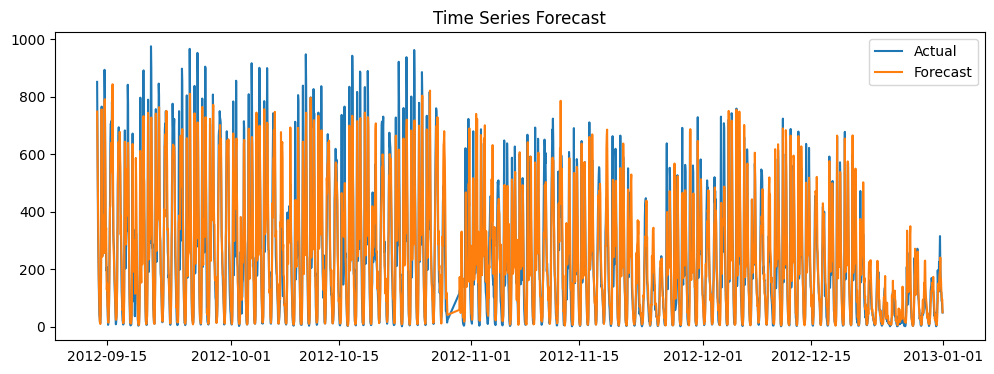

In [20]:

plt.figure(figsize=(12,4))
plt.plot(test["datetime"], y_test, label="Actual")
plt.plot(test["datetime"], y_pred, label="Forecast")
plt.legend()
plt.title("Time Series Forecast")
plt.show()



**Conclusion:**  
The forecasting model successfully captures daily and weekly patterns.
Compared to the regression model from Task 2, the time-series approach
is better suited for multi-step forecasting, while Task 2 excels at
what-if predictions based on external conditions.


## Declaration of Authorship


I hereby declare that this submission was created independently.
ChatGPT was used for structuring, explanation, and code scaffolding.
